<a href="https://colab.research.google.com/github/sp7412/colab/blob/master/distilling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Aug  6 14:49:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [4]:
GPUs = tf.config.experimental.list_physical_devices('GPU')
# get list of GPUs on host
if GPUs:
    print("Tensorflow detected GPUs")
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in GPUs:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(GPUs), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print("Memory growth must be set before GPUs have been initialized")
        print(e)

Tensorflow detected GPUs
1 Physical GPUs, 1 Logical GPUs


In [5]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

def softmax_sparse_categorical_crossentropy(labels, logits):
  softmaxed = tf.keras.backend.softmax(logits)

  return tf.keras.losses.sparse_categorical_crossentropy(labels, softmaxed)

In [6]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [7]:
num_classes = ds_info.features['label'].num_classes

In [8]:
ds_info.features['image'].shape

(28, 28, 1)

In [9]:
num_training_examples = ds_info.splits['train'].num_examples
num_training_examples

60000

In [10]:
ds_train_iter = ds_train.as_numpy_iterator()
train_images, train_labels = zip(*[ds_train_iter.next() for i in range(num_training_examples)])
train_images = np.asarray(train_images)

In [44]:
# labels are integers so we need to use sparse_categorical_crossentropy instead of categorical_crossentropy
train_labels[:2]

(1, 0)

Text(0.5, 1.0, '6')

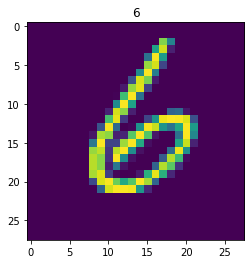

In [11]:
import matplotlib.pyplot as plt
idx = 10
plt.imshow(np.squeeze(train_images[idx]))
plt.title(train_labels[idx])

In [12]:
train_images.shape

(60000, 28, 28, 1)

In [13]:
num_testing_examples = ds_info.splits['test'].num_examples
num_testing_examples

10000

In [14]:
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
ds_test_iter = ds_test.as_numpy_iterator()

In [16]:
test_images, test_labels = zip(*[ds_test_iter.next() for i in range(num_testing_examples)])

In [17]:
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [23]:
control_model = tf.keras.models.Sequential([
  tf.keras.Input([28, 28]), 
  tf.keras.layers.Reshape([28, 28, 1]), 
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(), 
  tf.keras.layers.Dense(10, activation='softmax')])
  # tf.keras.layers.Dense(10, activation=None)])

control_model.compile('adam', 'sparse_categorical_crossentropy', ['accuracy'])
# control_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
# control_model.compile('adam', softmax_sparse_categorical_crossentropy, ['accuracy'])
control_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 64)        640       
_________________________________________________________________
batch_normalization_5 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 64)          36928     
_________________________________________________________________
batch_normalization_6 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 6, 6, 64)         

In [27]:
control_model.fit(train_images,np.asarray(train_labels), epochs=30,validation_split=0.2)

Epoch 1/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.7569 - accuracy: 0.7876 - val_loss: 0.3512 - val_accuracy: 0.9003
Epoch 2/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3116 - accuracy: 0.9101 - val_loss: 0.2254 - val_accuracy: 0.9377
Epoch 3/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2494 - accuracy: 0.9267 - val_loss: 0.2221 - val_accuracy: 0.9357
Epoch 4/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2206 - accuracy: 0.9324 - val_loss: 0.2010 - val_accuracy: 0.9408
Epoch 5/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2006 - accuracy: 0.9387 - val_loss: 0.1940 - val_accuracy: 0.9398
Epoch 6/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1874 - accuracy: 0.9422 - val_loss: 0.1646 - val_accuracy: 0.9505
Epoch 7/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1822 - accuracy: 0.9436 - val_loss: 0.1163 - val_accuracy:

In [28]:
test_loss, test_acc = control_model.evaluate(ds_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

79/79 [==============================] - 0s 2ms/step - loss: 0.0912 - accuracy: 0.9711
Test Loss: 0.09120030701160431
Test Accuracy: 0.9710999727249146


In [31]:
test_loss, test_acc = control_model.evaluate(np.asarray(test_images),np.asarray(test_labels))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.0912 - accuracy: 0.9711
Test Loss: 0.0912003442645073
Test Accuracy: 0.9710999727249146


In [35]:
teacher_model = tf.keras.models.Sequential([
  tf.keras.Input([28, 28]), 
  tf.keras.layers.Reshape([28, 28, 1]), 
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(), 
  #tf.keras.layers.Dense(10, activation='softmax')])
  tf.keras.layers.Dense(10, activation=None)])

# teacher_model.compile('adam', 'sparse_categorical_crossentropy', ['accuracy']) # awful
teacher_model.compile('adam', softmax_sparse_categorical_crossentropy, ['accuracy'])
teacher_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 64)        640       
_________________________________________________________________
batch_normalization_13 (Batc (None, 13, 13, 64)        256       
_________________________________________________________________
dropout_13 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 6, 6, 64)          36928     
_________________________________________________________________
batch_normalization_14 (Batc (None, 6, 6, 64)          256       
_________________________________________________________________
dropout_14 (Dropout)         (None, 6, 6, 64)         

In [36]:
teacher_model.fit(ds_train, epochs=40)

Epoch 1/40
469/469 [==============================] - 2s 4ms/step - loss: 0.3976 - accuracy: 0.8902
Epoch 2/40
469/469 [==============================] - 2s 4ms/step - loss: 0.1272 - accuracy: 0.9636
Epoch 3/40
469/469 [==============================] - 2s 4ms/step - loss: 0.0929 - accuracy: 0.9724
Epoch 4/40
469/469 [==============================] - 2s 4ms/step - loss: 0.0749 - accuracy: 0.9779
Epoch 5/40
469/469 [==============================] - 2s 4ms/step - loss: 0.0669 - accuracy: 0.9794
Epoch 6/40
469/469 [==============================] - 2s 4ms/step - loss: 0.0582 - accuracy: 0.9819
Epoch 7/40
469/469 [==============================] - 2s 4ms/step - loss: 0.0529 - accuracy: 0.9834
Epoch 8/40
469/469 [==============================] - 2s 4ms/step - loss: 0.0479 - accuracy: 0.9850
Epoch 9/40
469/469 [==============================] - 2s 4ms/step - loss: 0.0451 - accuracy: 0.9856
Epoch 10/40
469/469 [==============================] - 2s 4ms/step - loss: 0.0418 - accuracy: 0.9869

In [37]:
test_loss, test_acc = teacher_model.evaluate(ds_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

79/79 [==============================] - 0s 2ms/step - loss: 0.0315 - accuracy: 0.9916
Test Loss: 0.03152507171034813
Test Accuracy: 0.991599977016449


In [38]:
ds_train_images = tf.data.Dataset.from_tensor_slices(list(map(lambda x:tf.reshape(x,(-1,28,28,1)), train_images)))
soft_labels_train = teacher_model.predict(train_images,verbose=1)

1875/1875 [==============================] - 2s 1ms/step


In [39]:
soft_labels_train

array([[ -1.0065963 ,  14.832432  ,   0.95538414, ...,   3.1830795 ,
         -1.1765536 ,  -1.5471779 ],
       [ 21.29068   ,  -4.1315365 ,  -0.55932367, ...,  -6.327407  ,
         -5.881832  ,  -2.3061526 ],
       [ -4.356993  ,   6.273755  ,  -1.1109675 , ...,   3.6377504 ,
         -1.4271237 ,  -1.903285  ],
       ...,
       [  7.9176154 ,  -1.4114485 ,   0.23747845, ...,  -8.882339  ,
          0.26183182,  -9.117241  ],
       [ -2.809055  ,  17.37452   ,  -2.2765884 , ...,   2.0608976 ,
          0.8182487 ,  -1.8203354 ],
       [ -7.982747  , -12.50778   ,  -7.6023836 , ...,  -2.6798337 ,
          5.9955473 ,   2.7410467 ]], dtype=float32)

In [54]:
temperature = 3
afterwards_temperature = 1

def temperature_softmax(logits):
  soft_logits = tf.keras.backend.exp(logits / temperature)
  return soft_logits / tf.keras.backend.sum(soft_logits, axis=-1, keepdims=True) / afterwards_temperature

def distillation_loss(labels, logits):
  labels = temperature_softmax(labels)
  logits = temperature_softmax(logits)

  return -tf.keras.backend.mean(labels * tf.keras.backend.log(logits))

In [55]:
student_model = tf.keras.models.Sequential([
  tf.keras.Input([28, 28]), 
  tf.keras.layers.Reshape([28, 28, 1]), 
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(), 
  # tf.keras.layers.Dense(10, activation='softmax')])
  tf.keras.layers.Dense(10, activation=None)])

student_model.compile('adam', distillation_loss, ['accuracy'])
student_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 13, 13, 64)        640       
_________________________________________________________________
batch_normalization_24 (Batc (None, 13, 13, 64)        256       
_________________________________________________________________
dropout_24 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 6, 6, 64)          36928     
_________________________________________________________________
batch_normalization_25 (Batc (None, 6, 6, 64)          256       
_________________________________________________________________
dropout_25 (Dropout)         (None, 6, 6, 64)        

In [56]:
student_model.fit(train_images, soft_labels_train, epochs=50, validation_split=0.2)

Epoch 1/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1109 - accuracy: 0.7270 - val_loss: 0.0772 - val_accuracy: 0.8201
Epoch 2/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0552 - accuracy: 0.9015 - val_loss: 0.0520 - val_accuracy: 0.9118
Epoch 3/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0466 - accuracy: 0.9251 - val_loss: 0.0499 - val_accuracy: 0.9107
Epoch 4/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0432 - accuracy: 0.9355 - val_loss: 0.0375 - val_accuracy: 0.9557
Epoch 5/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0419 - accuracy: 0.9408 - val_loss: 0.0393 - val_accuracy: 0.9504
Epoch 6/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0409 - accuracy: 0.9428 - val_loss: 0.0394 - val_accuracy: 0.9499
Epoch 7/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0401 - accuracy: 0.9465 - val_loss: 0.0384 - val_accuracy:

temperature = 1 > loss: 0.0106 - accuracy: 0.9670 - val_loss: 0.0084 - val_accuracy: 0.9753

temperature = 3 > loss: 0.0350 - accuracy: 0.9672 - val_loss: 0.0321 - val_accuracy: 0.9725

temperature = 5 > loss: 0.0967 - accuracy: 0.9610 - val_loss: 0.0930 - val_accuracy: 0.9697

temperature = 7 > loss: 0.1481 - accuracy: 0.9581 - val_loss: 0.1462 - val_accuracy: 0.9645

In [57]:
# from https://stackoverflow.com/a/58547262/5495698
student_model.layers[-1].activation = tf.keras.activations.softmax

In [58]:
student_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [59]:
student_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 13, 13, 64)        640       
_________________________________________________________________
batch_normalization_24 (Batc (None, 13, 13, 64)        256       
_________________________________________________________________
dropout_24 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 6, 6, 64)          36928     
_________________________________________________________________
batch_normalization_25 (Batc (None, 6, 6, 64)          256       
_________________________________________________________________
dropout_25 (Dropout)         (None, 6, 6, 64)        

In [60]:
test_loss, test_acc = student_model.evaluate(ds_test, batch_size=128)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

79/79 [==============================] - 0s 2ms/step - loss: 0.1116 - accuracy: 0.9726
Test Loss: 0.11164765805006027
Test Accuracy: 0.972599983215332


In [62]:
test_loss, test_acc = student_model.evaluate(np.asarray(test_images),np.asarray(test_labels))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.1116 - accuracy: 0.9726
Test Loss: 0.11164768040180206
Test Accuracy: 0.972599983215332
